# CITS4403 - Perth Train Network from Slime Mould

22234771 - Benjamin Longbottom

## Imports

In [1]:
import numpy as np
import matplotlib.animation as ani
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

### Enable matplotlib interactive plots

In [2]:
%matplotlib notebook

## Utility Functions

In [3]:
def bounded_range(minimum, lower_request, upper_request, maximum):
    """ returns a range between lower and upper request, with hard boundaries at minimum and maximum. """
    
    return range(max(minimum, lower_request), min(maximum, upper_request))
    

## Grid Class

In [80]:
class Grid:
    """
    A grid in 2 dimensional space, with a single value assigned to each cell.
    
    - Cartesian plane
    - (x, y) indexing 
    - lower left origin
    """
    
    def __init__(self, shape=(200, 100), dtype=np.float32):
        self.shape = shape
        self.width, self.height = shape
        self._im = None
        self.dtype = dtype
        
        self.grid = self.setup_grid()
    
    def setup_grid(self):
        return self.clear_grid()
    
    
    # --- Grid Operations
    
    def clear_grid(self):
        self.grid = np.zeros((self.shape), dtype=self.dtype)
        return self.grid
    
    def randomise_grid(self):
        self.grid = np.random.rand(self.height, self.width)
        return self.grid
    
        
    def add_spot(self, centre_coords, value, radius=1):
        x_centre, y_centre = centre_coords
        
        for xi in bounded_range(0, x_centre-radius, x_centre+radius+1, self.width):
            for yi in bounded_range(0, y_centre-radius, y_centre+radius+1, self.height):
                self.grid[xi, yi] = value
    
    
    # --- Cell operations
    def get_neighbour_indicies(self, cell_coords):
        """ Returns a tuple of arrays: ( [x coords, ....], [y coords, ...] ) """
        cell_x, cell_y = cell_coords
        neighbours_x = np.array(bounded_range(0, cell_x-1, cell_x+2, self.width))
        neighbours_y = np.array(bounded_range(0, cell_y-1, cell_y+2, self.height))
            
        return (neighbours_x, neighbours_y)
    
    # --- Visualisation
    
    def draw(self, animated=False):
        """ Draws the current CA state on a 2D cartesian plane. """
        transposed_grid = self.grid.T
        if self._im is None:
            self._im = plt.imshow(transposed_grid, origin='lower', animated=animated, cmap='viridis')
        else:
            self._im.set_array(transposed_grid)
        return self._im
        

## Grid Types

In [81]:
class Diffusion_Grid(Grid):
    """ Diffuses values to neighbouring cells. """
    
    diffusion_kernel = np.array([[.05, .2, .05],
                                [ .2, -1, .2],
                                [.05, .2, .05]])
    
    def diffuse(self, diffusion_rate=0.5):
        diffusion_mask = correlate2d(self.grid, self.diffusion_kernel, mode='same')
        self.grid = self.grid + diffusion_rate * diffusion_mask
        return self.grid

In [82]:
class Distance_Grid(Grid):
    """ Expands outwards and stores distance from starting point. """

    dtype = np.int32
    background_value = 0
    moore_neighbourhood = np.array([[ [-1, -1], [0, -1], [1,-1] ],
                                    [ [-1, 0],  [0, 0],  [1,0]  ],
                                    [ [-1, 1],  [0, 1],  [1,1]  ]])

    
    def __init__(self, shape=(200, 100)):
        super().__init__(shape=(200, 100), dtype=self.dtype)
        self._edge_cells_set = set()
        self._edge_mask = None
        self._edge_indicies = None
        
        
    def setup_grid(self):
        self.grid = np.full(shape=self.shape, fill_value=self.background_value, dtype=self.dtype)
        return self.grid
    
    def step(self):
        return self.step_edge_memoised()
    
    def step_simple(self):
        occupied_cells = list(zip(*np.where(self.grid > self.background_value)))
        occupied_cell_set = set(occupied_cells)
        
        for cell in occupied_cell_set:
            neighbours_x, neighbours_y = self.get_neighbour_indicies(cell)
            for neighbour_x in neighbours_x:
                for neighbour_y in neighbours_y:
                    neighbour = (neighbour_x, neighbour_y)
                    if (neighbour_x, neighbour_y) not in occupied_cell_set:
                        if self.grid[neighbour] == 0 or self.grid[cell] + 1  < self.grid[neighbour]:
                            self.grid[neighbour] = self.grid[cell] + 1
        
        return self.grid
    
    def step_edge_set(self):
        if not self._edge_cells_set:
            occupied_cells = list(zip(*np.where(self.grid > self.background_value)))
            occupied_cell_set = set(occupied_cells)
            self._edge_cells_set = occupied_cell_set
        
        next_edge_set = set()
        
        for cell in self._edge_cells_set:
            neighbours_x, neighbours_y = self.get_neighbour_indicies(cell)
            for neighbour_x in neighbours_x:
                for neighbour_y in neighbours_y:
                    neighbour = (neighbour_x, neighbour_y)
                    if (neighbour_x, neighbour_y) not in self._edge_cells_set:
                        next_edge_set.add(neighbour)
                        if self.grid[neighbour] == self.background_value or self.grid[cell] + 1 < self.grid[neighbour]:
                            self.grid[neighbour] = self.grid[cell] + 1
        
        self._edge_cells_set = next_edge_set
        return self.grid
    
    def step_edge_memoised(self):
        if self._edge_indicies is None: 
#             edge_mask = np.full(self.shape, fill_value=0, dtype=np.int32)
            self._edge_indicies = np.where(self.grid > self.background_value)
        
        next_edge_indicies = {'x': [], 'y': []}
        
        for cell in zip(*self._edge_indicies):
            neighbours_x, neighbours_y = self.get_neighbour_indicies(cell)
            for neighbour_x in neighbours_x:
                for neighbour_y in neighbours_y:
                    neighbour = (neighbour_x, neighbour_y)
                    if self.grid[neighbour] == self.background_value or self.grid[cell] + 1 < self.grid[neighbour]:
                        next_edge_indicies['x'].append(neighbour_x)
                        next_edge_indicies['y'].append(neighbour_y)
                        self.grid[neighbour] = self.grid[cell] + 1
        
        self._edge_indicies = (next_edge_indicies['x'], next_edge_indicies['y'])
        return self.grid
        

In [83]:
dg = Distance_Grid()
dg.add_spot( (10, 20), 1, 0)
for _ in range(10):
    dg.step()
dg.draw()

## Slime Mould - Cellular Automata Model

In [84]:
class Slime_CA:
    
    def __init__(self, grid_shape=[20, 10]):
        self.grid_shape = grid_shape
        self.diffusion_grid = Diffusion_Grid(grid_shape)
        self.distance_grids = dict()
    
    def add_food(self, centre_point, radius=0):
        self.diffusion_grid.add_spot(centre_point, 100, radius)

        new_dist_grid = Distance_Grid(self.grid_shape)
        new_dist_grid.add_spot(centre_point, 1, 0)
        self.distance_grids[centre_point] = new_dist_grid
    
    def step(self):
        for distance_grid in self.distance_grids.values():
            return distance_grid.step()
#         return self.diffusion_grid.diffuse(diffusion_rate=0.5)
         
    def _draw_diffusion_grid(self, animated=False):
        return self.diffusion_grid.draw(animated=animated)
    
    def _draw_distance_grid(self, animated=False):
        return list(self.distance_grids.values())[0].draw(animated=animated)
    
    def draw(self, animated=False):
        return self._draw_distance_grid(animated)

## Cellular Automata Animator

In [89]:
class CA_Animator:
    
    def __init__(self, ca, fig=None):
        self.ca = ca
        if fig is None:
            fig = plt.figure()
        self.fig = fig
        self.current_frame = 0
     
    def animate(self, frame_count=10, interval=20):
        self.frame_count = frame_count
        
        self.anim = ani.FuncAnimation(
            self.fig, 
            self._update_frame, 
            init_func=self._setup_fig, 
            frames=self.frame_count, 
            interval=interval,
            repeat=False)
        
        plt.show()
        return self.anim
    
    def _setup_fig(self, *args):
        self.im = self.ca.draw(animated=True)
        return (self.im,)
    
    def _update_frame(self, frame_index):
        new_grid = self.ca.step()
        self.im = self.ca.draw()
        if frame_index <= self.frame_count:
            self.current_frame = frame_index
            return (self.im,)


## Running the Slime Mould CA model

<IPython.core.display.Javascript object>


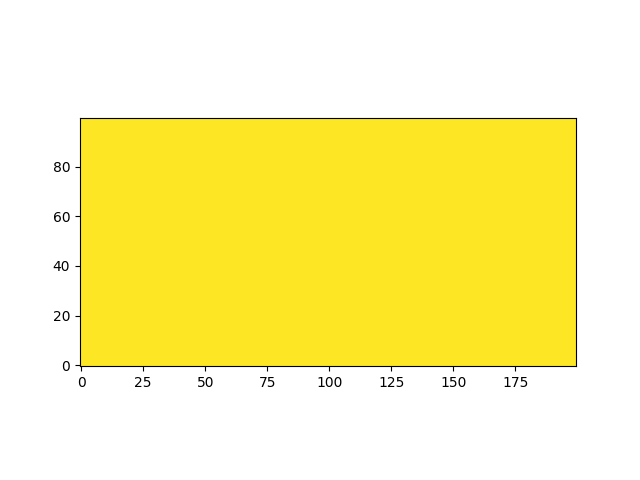

In [88]:
ca = Slime_CA(grid_shape=(200,100))
ca.add_food((20, 50), radius=1)
animator = CA_Animator(ca)
animator.animate(frame_count=500, interval=10)